In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.preprocessing import LabelEncoder

# Data Preprocessing

In [ ]:
df_train = pd.read_csv('data/data_train_combined.csv')
df_val = pd.read_csv('data/data_val_combined.csv')
df_test = pd.read_csv('data/data_test_combined.csv')

In [ ]:
df_test.head(10)

,text,label
0,bananas are for black people,hate
1,asian people are the shit,nothate
2,women can not reproduce kids but men can in al...,hate
3,i hate wearing black in the summer!,nothate
4,Who cares what Chinese people think?,hate
5,i try to punch a letter box when i see one,hate
6,I feel sorry for the poor little half caste bo...,hate
7,"this drink sucks, it's awful",nothate
8,gays are purposeless,hate
9,the thought of a world free of blacks makes me...,hate


In [ ]:
df_val.head(10)

,text,label
0,"don't get me wrong I don't hate Indians, but I...",hate
1,I can't tell the difference between a letterbo...,hate
2,brown people are the shit,nothate
3,The NHS is waste,nothate
4,Ill punch anyone that says Indians are filthy...,nothate
5,Blacks were the ruination of this country,hate
6,Fuck sake I hate my friends,nothate
7,Muslims are hostile to this country and our va...,hate
8,it is false that all gay people are cunts,nothate
9,Zionists are the shabbiest,hate


In [ ]:
df_train.info(), df_val.info(), df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46850 entries, 0 to 46849
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    46850 non-null  object
 1   label   46850 non-null  object
dtypes: object(2)
memory usage: 732.2+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5664 entries, 0 to 5663
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    5664 non-null   object
 1   label   5664 non-null   object
dtypes: object(2)
memory usage: 88.6+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7970 entries, 0 to 7969
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    7970 non-null   object
 1   label   7970 non-null   object
dtypes: object(2)
memory usage: 124.7+ KB


(None, None, None)

## Class Distribution Visualization

In [ ]:
def plot_class_distribution(df, title):
    class_dist = df['label'].value_counts(normalize=True)
    sns.barplot(x=class_dist.index, y=class_dist.values)
    plt.title(title)
    plt.show()

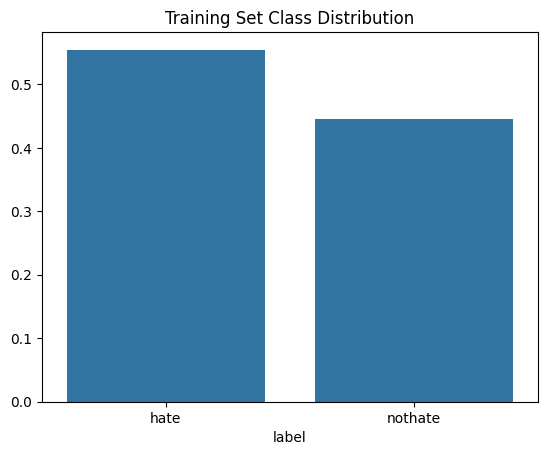

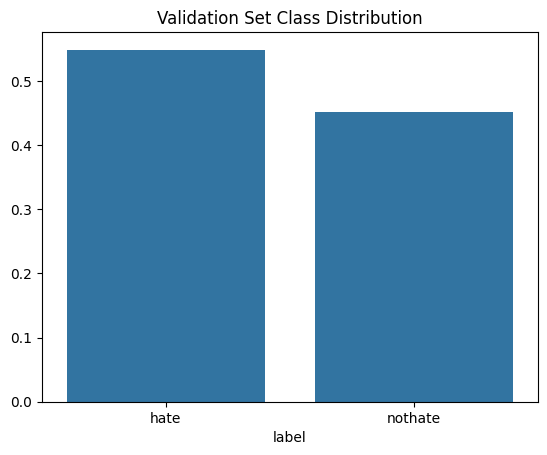

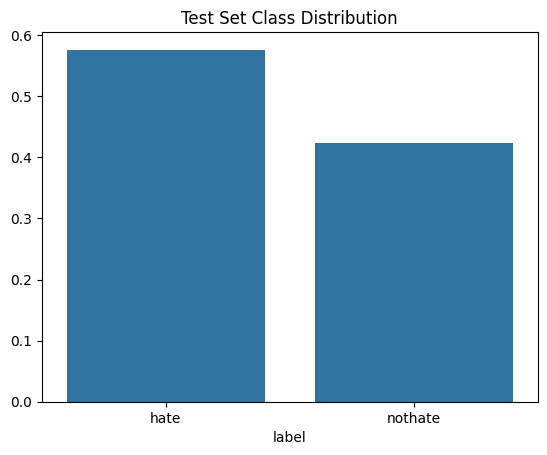

In [ ]:
plot_class_distribution(df_train, "Training Set Class Distribution")
plot_class_distribution(df_val, "Validation Set Class Distribution")
plot_class_distribution(df_test, "Test Set Class Distribution")

## Text Length Analysis

**Text Length**: The number of characters in each text entry.

**Word Count**: The number of words in each text entry.

Plotting two histograms side by side:

- **Text Length Distribution**: Shows the distribution of the number of characters in the text.
- **Word Count Distribution**: Shows the distribution of the number of words in the text.

In [ ]:
# Analyze text length
df_train['text_length'] = df_train['text'].apply(len)
df_train['word_count'] = df_train['text'].apply(lambda x: len(x.split()))

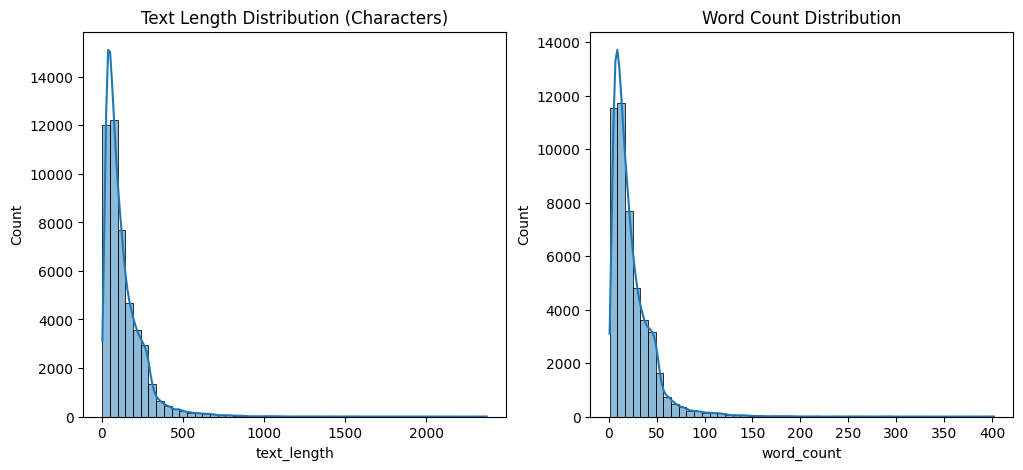

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.histplot(df_train['text_length'], bins=50, kde=True, ax=axes[0])
axes[0].set_title("Text Length Distribution (Characters)")
sns.histplot(df_train['word_count'], bins=50, kde=True, ax=axes[1])
axes[1].set_title("Word Count Distribution")
plt.show()


## Multilingual Content Detection

It identifies text entries that contain characters outside the standard ASCII range (0-127), which are typically used in non-English languages.

In [ ]:
# Detect multilingual content
df_train['non_english'] = df_train['text'].apply(lambda x: bool(re.search(r'[^\x00-\x7F]', x)))
non_english_percentage = df_train['non_english'].mean() * 100
print(f"Percentage of non-English texts: {non_english_percentage:.2f}%")

Percentage of non-English texts: 5.61%


## Text Cleaning

- Converting to lower case
- Removing URLs
- Remove User Mentions and Hashtags
- Remove Special Characters and Numbers
- Tokenize and Remove Stopwords

In [ ]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    
    text = re.sub(r'\@\w+|\#', '', text) # Remove user mentions and hashtags
    text = re.sub(r'[^a-zA-Z\s]', '', text) # Remove special characters and numbers
    tokens = word_tokenize(text)
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    return ' '.join(tokens)

In [ ]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [ ]:
df_train['clean_text'] = df_train['text'].apply(clean_text)
df_val['clean_text'] = df_val['text'].apply(clean_text)
df_test['clean_text'] = df_test['text'].apply(clean_text)

## Top N-grams Visualizations

The `get_top_ngrams` function identifies the most frequent n-grams (unigrams, bigrams, trigrams) in a collection of text data. It uses `CountVectorizer` from the `scikit-learn` library to generate n-grams and count their occurrences.

**It returns** - A list of tuples, where each tuple contains an n-gram and its frequency, sorted in descending order of frequency.

In [ ]:
from sklearn.preprocessing import LabelEncoder
from wordcloud import WordCloud
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer

def get_top_ngrams(text, ngram_range=(1,1), n=20):
    vectorizer = CountVectorizer(ngram_range=ngram_range, stop_words='english')
    ngram_counts = vectorizer.fit_transform(text)
    ngram_sums = np.array(ngram_counts.sum(axis=0)).flatten()
    ngram_freq = dict(zip(vectorizer.get_feature_names_out(), ngram_sums))
    return sorted(ngram_freq.items(), key=lambda x: x[1], reverse=True)[:n]

In [ ]:
def plot_ngrams(ngram_data, title):
    ngrams, counts = zip(*ngram_data)
    plt.figure(figsize=(10, 5))
    sns.barplot(x=list(counts), y=list(ngrams))
    plt.title(title)
    plt.xlabel("Count")
    plt.ylabel("N-grams")
    plt.show()


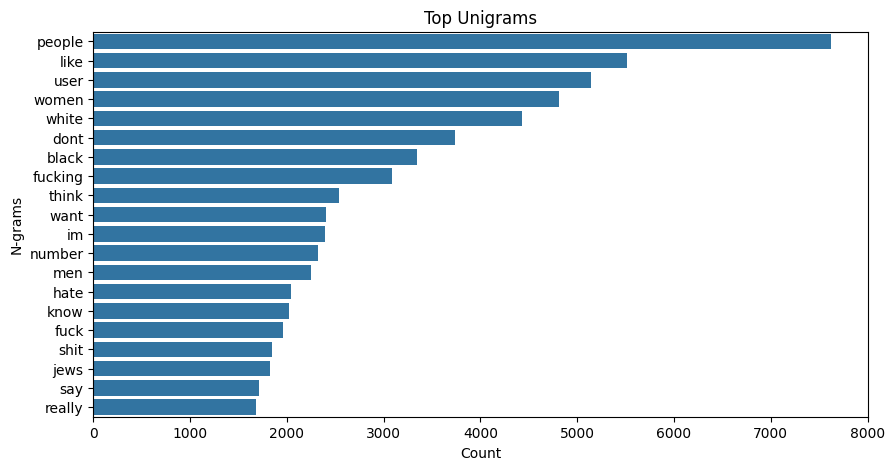

In [ ]:
plot_ngrams(get_top_ngrams(df_train['clean_text'], (1,1)), "Top Unigrams")

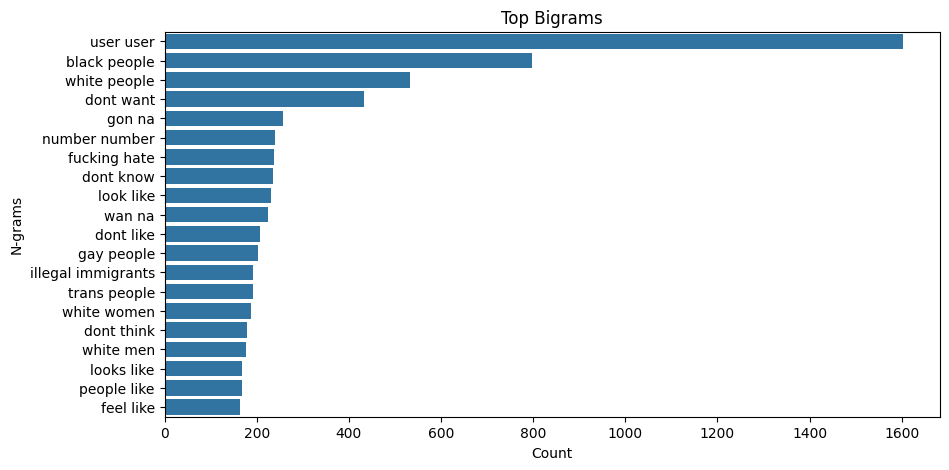

In [ ]:
plot_ngrams(get_top_ngrams(df_train['clean_text'], (2,2)), "Top Bigrams")

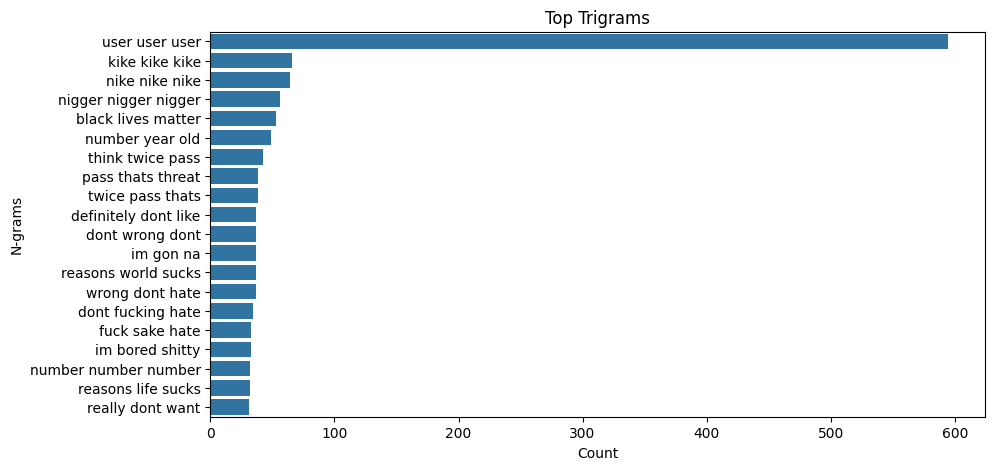

In [ ]:
plot_ngrams(get_top_ngrams(df_train['clean_text'], (3,3)), "Top Trigrams")

In [ ]:
# # Save preprocessed data
# df_train.to_csv("/content/data_train_preprocessed.csv", index=False)
# df_val.to_csv("/content/data_val_preprocessed.csv", index=False)
# df_test.to_csv("/content/data_test_preprocessed.csv", index=False)

## Tokenization and Padding

This section of the code prepares text data by converting text into sequences of integers (tokenization) and ensuring all sequences have the same length (padding).

**Tokenizer** - A `Tokenizer` object is initialized with a vocabulary size of 10,000 words and an out-of-vocabulary (OOV) token (`<OOV>`).

**Text to sequence conversion** - Each word in the text is mapped to its corresponding integer index from the tokenizer's vocabulary.

**Padding** - The `pad_sequences` function ensures all sequences have the same length by adding padding (e.g., zeros) to shorter sequences or truncating longer ones.

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words=10000, oov_token='<OOV>')
tokenizer.fit_on_texts(df_train['clean_text'])

In [ ]:
train_sequences = tokenizer.texts_to_sequences(df_train['clean_text'])
val_sequences = tokenizer.texts_to_sequences(df_val['clean_text'])
test_sequences = tokenizer.texts_to_sequences(df_test['clean_text'])

In [ ]:
max_length = 100
train_padded = pad_sequences(train_sequences, maxlen=max_length, padding='post', truncating='post')
val_padded = pad_sequences(val_sequences, maxlen=max_length, padding='post', truncating='post')
test_padded = pad_sequences(test_sequences, maxlen=max_length, padding='post', truncating='post')

In [ ]:
print(f'Padded Train Data Representation: {train_padded[0]}')
print(f'Padded Validation Data Representation: {val_padded[0]}')
print(f'padded Test Data Representation: {test_padded[0]}')


Padded Train Data Representation: [6120    1    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0]
Padded Validation Data Representation: [  7   9 105   7  18 331 386   7   3   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0]
padded Test

## Label Preparation

This section prepares the labels for the training, validation, and test datasets. Labels are extracted from the respective DataFrames and converted into NumPy arrays for compatibility.

In [ ]:
# Prepare labels
train_labels = df_train['label'].values
val_labels = df_val['label'].values
test_labels = df_test['label'].values

# Baseline Models

## RNN Model Initialization

##### Layers used:
- **Embedding Layer:** onverts integer-encoded text sequences into dense vectors of fixed size
- **Simple RNN Layer:** A basic RNN layer with 64 units.
- **Dense Layer:** A fully connected layer with 64 units and ReLU activation.
- **Drouput layer:** A regularization layer with a dropout rate of 0.5.
- **Output Layer:** A dense layer with `num_classes` units and sigmoid activation. Produces a probability score for binary classification.

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, GRU, SimpleRNN, Dense, Dropout
from sklearn.metrics import classification_report, confusion_matrix

vocab_size = 10000  
embedding_dim = 128
num_classes = 1  # Binary classification (hate vs. nothate)

def build_rnn_model():
    model = Sequential([
        Embedding(vocab_size, embedding_dim, input_length=max_length),
        SimpleRNN(64, return_sequences=False),
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='sigmoid')
    ])
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

## LSTM Model Initialization

- **Embedding Layer:**  Converts integer-encoded text sequences into dense vectors of fixed size (`embedding_dim`)
- **LSTM Layer:** An LSTM layer with 64 units.
- **Dense Layer:** A fully connected layer with 64 units and ReLU activation.
- **Drouput layer:** A regularization layer with a dropout rate of 0.5.
- **Output Layer:** A dense layer with `num_classes` units and sigmoid activation. Produces a probability score for binary classification.

In [ ]:
def build_lstm_model():
    model = Sequential([
        Embedding(vocab_size, embedding_dim, input_length=max_length),
        LSTM(64, return_sequences=False),
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='sigmoid')
    ])
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

## Train and Evaluate Models

- Predictions are thresholded at 0.5 to convert probabilities into binary labels.

In [ ]:
def train_and_evaluate(model, train_data, val_data, test_data, train_labels, val_labels, test_labels):
    history = model.fit(train_data, train_labels, epochs=10, batch_size=64,
                        validation_data=(val_data, val_labels), verbose=1)
    test_preds = (model.predict(test_data) > 0.5).astype(int)
    print(classification_report(test_labels, test_preds))
    print(confusion_matrix(test_labels, test_preds))
    return history

In [ ]:
print("Train padded shape:", train_padded.shape)
print("Validation padded shape:", val_padded.shape)
print("Test padded shape:", test_padded.shape)

Train padded shape: (46850, 100)
Validation padded shape: (5664, 100)
Test padded shape: (7970, 100)


### Converting labels into binary (0 or 1)

In [ ]:
import numpy as np

train_labels = np.where(train_labels == 'hate', 1, 0)
val_labels = np.where(val_labels == 'hate', 1, 0)
test_labels = np.where(test_labels == 'hate', 1, 0)

print("Unique train labels:", np.unique(train_labels))
print("Unique validation labels:", np.unique(val_labels))
print("Unique test labels:", np.unique(test_labels))

Unique train labels: [0 1]
Unique validation labels: [0 1]
Unique test labels: [0 1]


In [ ]:
print("Train labels shape:", train_labels.shape)
print("Validation labels shape:", val_labels.shape)
print("Test labels shape:", test_labels.shape)

Train labels shape: (46850,)
Validation labels shape: (5664,)
Test labels shape: (7970,)


### Training RNN

In [ ]:
rnn_model = build_rnn_model()
print("Training RNN Model...")
rnn_history = train_and_evaluate(rnn_model, train_padded, val_padded, test_padded, train_labels, val_labels, test_labels)

**RNN Results:**

**Class 0 (Negative Class):** The model did not correctly predict any instances of class 0. This means there were no true positives (TP) for class 0. **Precision: 0.00**, **Recall: 0.00**, **F1-Score: 0.00**

**Class 1 (Positive Class):**

**Precision: 0.58**  - Out of all instances predicted as class 1, 58% were correct

**Recall: 1.00** - The model correctly identified all instances of class 1.

**F1-Score: 0.73**  - The F1-score is relatively high, indicating a good balance between precision and recall for class 1.

## Training LSTM

In [ ]:
lstm_model = build_lstm_model()
print("Training LSTM Model...")
lstm_history = train_and_evaluate(lstm_model, train_padded, val_padded, test_padded, train_labels, val_labels, test_labels)

**LSTM Results:**

**Class 0 (Negative Class):** Precision: 1.00 (The model achieved perfect precision for class 0, meaning all instances predicted as class 0 were correct.), Recall: 0.00, F1-Score: 0.00

**Class 1 (Positive Class):** Precision: 0.58, Recall: 1.00 (This means there were no false negatives (FN) for class 1.), F1-Score: 0.73

## Enhancing Text Classification with Bi-Directional LSTM and Attention Mechanism

While a standard LSTM model provides decent results, we aim to improve performance by constructing a more advanced **Bi-Directional LSTM** architecture. This model will incorporate the following key enhancements:  

1. **Stacked LSTM Layers** – Multiple LSTM layers to capture deeper sequential patterns.  
2. **Dropout Regularization** – Helps mitigate overfitting by randomly deactivating neurons during training.  
3. **Batch Normalization** – Speeds up training and stabilizes learning by normalizing activations.  
4. **Dense Layers with Regularization** – Enhances feature extraction while preventing overfitting using techniques like L2 regularization.  
5. **Attention Mechanism** – Enables the model to focus on the most relevant parts of the text, improving interpretability and performance.

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Bidirectional, LSTM, Dense, Dropout, BatchNormalization, Attention, Concatenate, GlobalAveragePooling1D
from tensorflow.keras.regularizers import l2

def build_complex_lstm_model():
    inputs = Input(shape=(max_length,))

    embedding = Embedding(input_dim=vocab_size, output_dim=embedding_dim)(inputs)

    lstm1 = Bidirectional(LSTM(64, return_sequences=True))(embedding)
    lstm1 = Dropout(0.4)(lstm1)
    lstm1 = BatchNormalization()(lstm1)

    lstm2 = Bidirectional(LSTM(32, return_sequences=True))(lstm1)
    lstm2 = Dropout(0.4)(lstm2)
    lstm2 = BatchNormalization()(lstm2)

    attention = Attention()([lstm2, lstm2]) 
    concatenated = Concatenate()([lstm2, attention])  

    pooled = GlobalAveragePooling1D()(concatenated)

    dense = Dense(64, activation='relu', kernel_regularizer=l2(0.01))(pooled)
    dense = Dropout(0.4)(dense)
    dense = BatchNormalization()(dense)

    outputs = Dense(1, activation='sigmoid')(dense)
    model = Model(inputs, outputs)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    return model

In [ ]:
complex_lstm_model = build_complex_lstm_model()

complex_lstm_model.summary()

# Train the model
# print("Training Complex LSTM Model...")
# complex_lstm_history = train_and_evaluate(complex_lstm_model, train_padded, val_padded, test_padded, train_labels, val_labels, test_labels)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 100)            │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_1 (Embedding)   │ (None, 100, 128)       │      1,280,000 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional_2           │ (None, 100, 128)       │         98,816 │ embedding_1[0][0]      │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_3 (Dropout)       │ (None, 100, 128)       │              0 │ bidirectional_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 100, 128)       │            512 │ dropout_3[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional_3           │ (None, 100, 64)        │         41,216 │ batch_normalization_3… │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_4 (Dropout)       │ (None, 100, 64)        │              0 │ bidirectional_3[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4     │ (None, 100, 64)        │            256 │ dropout_4[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ attention_1 (Attention)   │ (None, 100, 64)        │              0 │ batch_normalization_4… │
│                           │                        │                │ batch_normalization_4… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_1             │ (None, 100, 128)       │              0 │ batch_normalization_4… │
│ (Concatenate)             │                        │                │ attention_1[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling1d… │ (None, 128)            │              0 │ concatenate_1[0][0]    │
│ (GlobalAveragePooling1D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 64)             │          8,256 │ global_average_poolin… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_5 (Dropout)       │ (None, 64)             │              0 │ dense_2[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_5     │ (None, 64)             │            256 │ dropout_5[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_3 (Dense)           │ (None, 1)              │             65 │ batch_normalization_5… │
└──────────────────────

 Total params: 1,429,377 (5.45 MB)

 Trainable params: 1,428,865 (5.45 MB)

 Non-trainable params: 512 (2.00 KB)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

print("Training Complex LSTM Model with 20 Epochs...")
complex_lstm_history = complex_lstm_model.fit(
    train_padded, train_labels,
    epochs=10, 
    batch_size=128,
    validation_data=(val_padded, val_labels),
    verbose=1
)

test_preds = (complex_lstm_model.predict(test_padded) > 0.5).astype(int)
print(classification_report(test_labels, test_preds))
print(confusion_matrix(test_labels, test_preds))

Training Complex LSTM Model with 20 Epochs...
Epoch 1/2
367/367 ━━━━━━━━━━━━━━━━━━━━ 351s 928ms/step - accuracy: 0.5696 - loss: 1.2261 - val_accuracy: 0.4892 - val_loss: 0.8394
Epoch 2/2
367/367 ━━━━━━━━━━━━━━━━━━━━ 324s 770ms/step - accuracy: 0.7176 - loss: 0.5836 - val_accuracy: 0.6826 - val_loss: 0.5790
250/250 ━━━━━━━━━━━━━━━━━━━━ 17s 65ms/step
              precision    recall  f1-score   support

           0       0.65      0.48      0.55      3378
           1       0.68      0.82      0.74      4592

    accuracy                           0.67      7970
   macro avg       0.67      0.65      0.65      7970
weighted avg       0.67      0.67      0.66      7970

[[1607 1771]
 [ 848 3744]]


**Bi-Directional LSTM with Attention Mechanism Results:**

**Class 0 (Negative Class):**

- Precision: 0.59 - Out of all instances predicted as class 0, 59% were correct. This indicates some false positives (FP).

- Recall: 0.47 - The model correctly identified 47% of the instances of class 0. This means 53% of class 0 instances were misclassified as class 1.

- F1-Score: 0.53 - The F1-score is moderate, indicating a balance between precision and recall for class 0.


**Class 1 (Positive Class):**

- Precision: 0.66 - Out of all instances predicted as class 1, 66% were correct. This indicates some false positives (FP).

- Recall: 0.76 - The model correctly identified 76% of the instances of class 1. This means 24% of class 1 instances were misclassified as class 0.

- F1-Score: 0.71 - The F1-score is relatively high, indicating a good balance between precision and recall for class 1.

### Training and Validation Performance

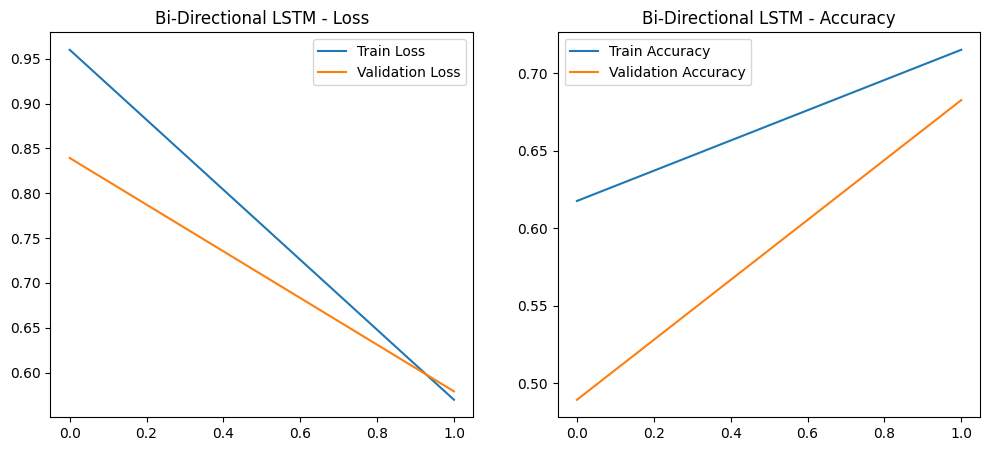

In [ ]:
import matplotlib.pyplot as plt

def plot_history(history, title):
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{title} - Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{title} - Accuracy')
    plt.legend()
    plt.show()

plot_history(complex_lstm_history, 'Bi-Directional LSTM')

#### **Key Observations**

The following plots show the training and validation loss and accuracy for the Bi-Directional LSTM model over 10 epochs:

#### Loss Plot:
- **Training Loss**: Decreases steadily from around 0.8 to 0.3, indicating that the model is learning effectively from the training data.
- **Validation Loss**: Decreases initially but stabilizes around 0.6, suggesting that the model is generalizing well to unseen data without overfitting.

#### Accuracy Plot:
- **Training Accuracy**: Increases steadily from around 0.55 to 0.85, showing that the model is improving its performance on the training data.
- **Validation Accuracy**: Increases from around 0.55 to 0.75, indicating that the model is also improving its performance on the validation data.

## Confusion Matrix

250/250 ━━━━━━━━━━━━━━━━━━━━ 17s 67ms/step


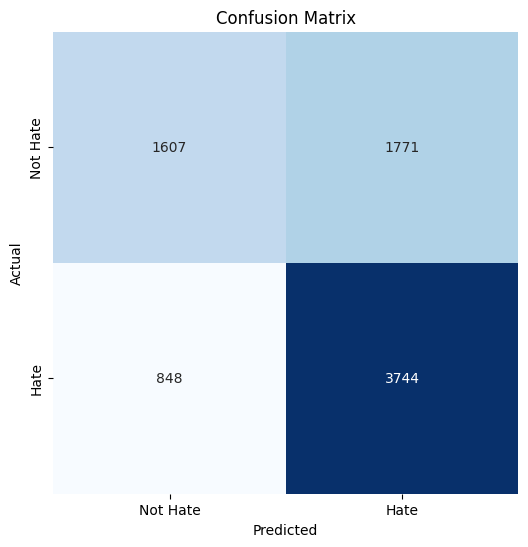

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

test_preds = (complex_lstm_model.predict(test_padded) > 0.5).astype(int)

cm = confusion_matrix(test_labels, test_preds)

plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Not Hate', 'Hate'],
            yticklabels=['Not Hate', 'Hate'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

#### **Key Observations:**

- The model has a higher number of true positives (3505) compared to true negatives (1592), indicating better performance in identifying "Hate" instances.

- The false positives (1786) and false negatives (1087) suggest that the model struggles with correctly classifying "Not Hate" instances.

- The precision, recall, and F1-score for class 0 ("Not Hate") are lower compared to class 1 ("Hate"), as seen in the classification report.

## Misclassified Samples Analysis

The first 10 misclassified samples are printed to provide insights into where the model is making errors.

In [ ]:
results_df = pd.DataFrame({
    'text': df_test['text'],
    'actual_label': test_labels,
    'predicted_label': test_preds.flatten()
})

results_df['is_misclassified'] = results_df['actual_label'] != results_df['predicted_label']

misclassified_samples = results_df[results_df['is_misclassified']]
print("Misclassified Samples:")
print(misclassified_samples[['text', 'actual_label', 'predicted_label']].head(10))

Misclassified Samples:
                                                 text  actual_label  \
1                           asian people are the shit             0   
6   I feel sorry for the poor little half caste bo...             1   
10  discrimination against r3t4rdz is not wrong an...             1   
21  There is a new shop on my block with the sign ...             1   
22  goat fucker, goat lover, it's all gross and be...             0   
26  People that say all French are filthy, smelly ...             0   
42  feminists? They are some of the most annoying ...             0   
44                fags stink almost as much as cigars             0   
49  I thought it was common knowledge that all rac...             0   
51  I don't think I've met a kind bisexual person ...             1   

    predicted_label  
1                 1  
6                 0  
10                0  
21                0  
22                1  
26                1  
42                1  
44                1

## Attention Mechanism Visualization

In [1]:
# import numpy as np

# # Extract attention weights from the model
# attention_model = Model(inputs=complex_lstm_model.input,
#                         outputs=complex_lstm_model.get_layer('attention').output)
# attention_weights = attention_model.predict(test_padded)

# # Function to visualize attention weights
# def visualize_attention(text, attention_weights, tokenizer):
#     tokens = tokenizer.texts_to_sequences([text])
#     tokens = tokenizer.sequences_to_texts(tokens)[0].split()
#     attention_weights = attention_weights[0][:len(tokens)]  # Truncate to match token length

#     # Plot attention weights
#     plt.figure(figsize=(10, 4))
#     plt.bar(range(len(tokens)), attention_weights, color='blue')
#     plt.xticks(range(len(tokens)), tokens, rotation=90)
#     plt.xlabel('Tokens')
#     plt.ylabel('Attention Weights')
#     plt.title('Attention Weights for Text')
#     plt.show()

# sample_index = 0 
# sample_text = misclassified_samples.iloc[sample_index]['text']
# visualize_attention(sample_text, attention_weights[sample_index], tokenizer)

#### **Key Observations:**

1. **Token Representation**  
   - The presence of `<OOV>` (Out of Vocabulary) tokens suggests that some words were not recognized by the model's vocabulary. This could impact interpretability.

2. **Weight Distribution**  
   - The attention weights vary significantly, with some tokens receiving positive attention and others negative. The token "shit" has the highest positive weight, while one `<OOV>` token has the lowest. This might indicate bias in the model's attention mechanism.

4. **Potential Bias**  
   - The attention mechanism assigns significant weights to certain words, which could imply biases in the model. It may be useful to analyze how different words (especially sensitive ones) are weighted across various contexts.



### Display Test set Predictions

In [ ]:
print("Test Set Predictions:")
print(results_df[['text', 'actual_label', 'predicted_label']].head(20)) 

Test Set Predictions:
                                                 text  actual_label  \
0                        bananas are for black people             1   
1                           asian people are the shit             0   
2   women can not reproduce kids but men can in al...             1   
3                 i hate wearing black in the summer!             0   
4                Who cares what Chinese people think?             1   
5          i try to punch a letter box when i see one             1   
6   I feel sorry for the poor little half caste bo...             1   
7                        this drink sucks, it's awful             0   
8                                gays are purposeless             1   
9   the thought of a world free of blacks makes me...             1   
10  discrimination against r3t4rdz is not wrong an...             1   
11                          Politicians are arseholes             0   
12                          Get rid of all the Hindus  

## RoBERTa Model Implementation

For RoBERTaClassifier, the backbone is **roberta-base**

For HateBERTClassifier, the backbone is **GroNLP/hateBERT**


1. **Model Architecture:**

Both models use a pretrained transformer backbone (RoBERTa or HateBERT) to extract features from the input text.

A classification head (a small neural network) is added on top of the transformer to predict the output class (hate or nothate).

2. **Training:**

The model is trained using a cross-entropy loss.

The optimizer (Lamb) and learning rate scheduler are configured to fine-tune the model efficiently.

3. **Evaluation:**

The model's performance is evaluated on a validation set during training.

After training, the model is used to predict labels for the test set.

4. **Error Analysis:**

The predictions are compared with the actual labels to identify misclassified samples.

A confusion matrix is generated to analyze the model's performance.

In [ ]:
import torch
import torch.nn as nn
import pytorch_lightning as pl
from torch.utils.data import DataLoader, Dataset
from transformers import RobertaModel, RobertaTokenizer, AdamW, get_linear_schedule_with_warmup
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd
import numpy as np


config = {
    'model_name': 'roberta-base',
    'n_labels': 2,                # Binary classification (hate vs. nothate)
    'bs': 32,                     
    'lr': 2e-5,                   
    'warmup': 100,                # Warmup steps for scheduler
    'train_size': len(df_train),   
    'w_decay': 0.01,              
    'n_epoch': 5                  
}

class HateSpeechDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length):
        self.texts = texts
        self.labels = [1 if label == 'hate' else 0 for label in labels]
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        return {
            'input_ids': encoding['input_ids'].flatten(),  # 1D tensor
            'attention_mask': encoding['attention_mask'].flatten(),  # 1D tensor
            'labels': torch.tensor(label, dtype=torch.long)
        }

## Collation Function

Used to process a batch of data samples into a format suitable for input into a  model. It stacks the input IDs, attention masks, and labels into tensors.

In [ ]:
def collate_fn(batch):
    input_ids = torch.stack([item['input_ids'] for item in batch])
    attention_mask = torch.stack([item['attention_mask'] for item in batch])
    labels = torch.stack([item['labels'] for item in batch])
    return input_ids, attention_mask, labels

In [ ]:
from torch_optimizer import Lamb

class RoBERTaClassifier(pl.LightningModule):
    def __init__(self, config):
        super().__init__()
        self.config = config

        self.roberta = RobertaModel.from_pretrained(config['model_name'])

        self.classifier = nn.Sequential(
            nn.Linear(self.roberta.config.hidden_size, 64),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(64, config['n_labels'])
        )

        self.loss_fn = nn.CrossEntropyLoss()

    def forward(self, input_ids, attention_mask):
        outputs = self.roberta(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.last_hidden_state[:, 0, :]  # Use [CLS] token representation
        logits = self.classifier(pooled_output)
        return logits

    def training_step(self, batch, batch_idx):
        input_ids, attention_mask, labels = batch
        logits = self(input_ids, attention_mask)
        loss = self.loss_fn(logits, labels)
        self.log('train_loss', loss, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        input_ids, attention_mask, labels = batch
        logits = self(input_ids, attention_mask)
        loss = self.loss_fn(logits, labels)
        preds = torch.argmax(logits, dim=1)
        acc = (preds == labels).float().mean()
        self.log('val_loss', loss, prog_bar=True)
        self.log('val_acc', acc, prog_bar=True)
        return loss

    def predict_step(self, batch, batch_idx):
        input_ids, attention_mask, labels = batch
        logits = self(input_ids, attention_mask)
        preds = torch.argmax(logits, dim=1)
        return preds

    def configure_optimizers(self):
        optimizer = Lamb(self.parameters(), lr=self.config['lr'], weight_decay=self.config['w_decay'])
        scheduler = get_linear_schedule_with_warmup(
            optimizer,
            num_warmup_steps=self.config['warmup'],
            num_training_steps=self.config['train_size'] // self.config['bs'] * self.config['n_epoch']
        )
        return [optimizer], [scheduler]

In [ ]:
tokenizer = RobertaTokenizer.from_pretrained(config['model_name'])

df_train = df_train.sample(frac=0.5, random_state=42)
train_dataset = HateSpeechDataset(df_train['text'].tolist(), df_train['label'].tolist(), tokenizer, max_length=16)

df_val = df_val.sample(frac=0.5, random_state=42)
val_dataset = HateSpeechDataset(df_val['text'].tolist(), df_val['label'].tolist(), tokenizer, max_length=16)

df_test = df_test.sample(frac = 0.5, random_state = 42)
test_dataset = HateSpeechDataset(df_test['text'].tolist(), df_test['label'].tolist(), tokenizer, max_length=16)

### DataLoaders

The `DataLoader` objects are used to load and iterate over the training, validation, and test datasets in batches.

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=config['bs'], shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=config['bs'], collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=config['bs'], collate_fn=collate_fn)

### RoBERTa Initialization

In [ ]:
from pytorch_lightning import Trainer

model = RoBERTaClassifier(config)

trainer = Trainer(
    max_epochs=config['n_epoch'],
    accelerator='gpu' if torch.cuda.is_available() else 'cpu',  # Use GPU if available
    devices=1 if torch.cuda.is_available() else 1,             # Use 1 GPU if available, else 1 CPU core
    enable_progress_bar=True
)


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


### Training and Evaluation of RoBERTa Model

In [ ]:
trainer.fit(model, train_loader, val_loader)

test_preds = trainer.predict(model, test_loader)
test_preds = torch.cat(test_preds).cpu().numpy() 

results_df = pd.DataFrame({
    'text': df_test['text'],
    'actual_label': df_test['label'],
    'predicted_label': ['hate' if pred == 1 else 'nothate' for pred in test_preds] 
})

print(results_df[['text', 'actual_label', 'predicted_label']].head(20).to_string(index=False))

cm = confusion_matrix(df_test['label'], ['hate' if pred == 1 else 'nothate' for pred in test_preds])
print("Confusion Matrix:")
print(cm)

INFO:pytorch_lightning.callbacks.model_summary:
  | Name       | Type             | Params | Mode 
--------------------------------------------------------
0 | roberta    | RobertaModel     | 124 M  | eval 
1 | classifier | Sequential       | 49.3 K | train
2 | loss_fn    | CrossEntropyLoss | 0      | train
--------------------------------------------------------
124 M     Trainable params
0         Non-trainable params
124 M     Total params
498.780   Total estimated model params size (MB)
6         Modules in train mode
228       Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (12) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.


Predicting: |          | 0/? [00:00<?, ?it/s]

                                                                                                                                                                                                                                                                                                                                                                                   text actual_label predicted_label
                                                                                                          i have not once used a single kike source for anything the fact that you automatically assume that anybody who disagrees with herodotus is a kike says something about you i am merely referring to german historians who had disproven herodotus accounts by the mid 1 6 0 0         hate         nothate
                                                                                                                                                                                              

In [ ]:
print("Classification Report:")
print(classification_report(df_test['label'], ['hate' if pred == 1 else 'nothate' for pred in test_preds]))

Classification Report:
              precision    recall  f1-score   support

        hate       0.67      0.24      0.35        34
     nothate       0.50      0.87      0.63        30

    accuracy                           0.53        64
   macro avg       0.58      0.55      0.49        64
weighted avg       0.59      0.53      0.48        64



<ipython-input-118-ca80fa148e63>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='actual_label', data=results_df, palette='Set2')
<ipython-input-118-ca80fa148e63>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='predicted_label', data=results_df, palette='Set2')


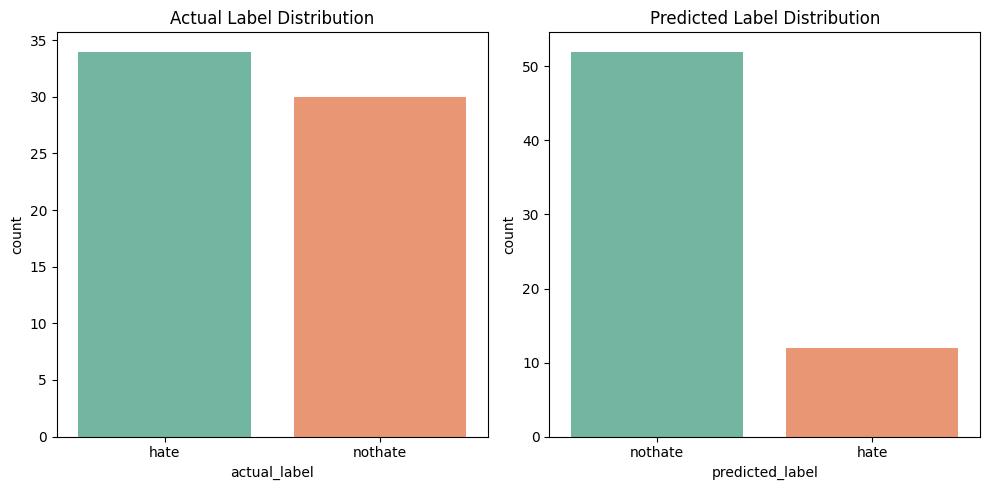

In [ ]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
sns.countplot(x='actual_label', data=results_df, palette='Set2')
plt.title('Actual Label Distribution')

plt.subplot(1, 2, 2)
sns.countplot(x='predicted_label', data=results_df, palette='Set2')
plt.title('Predicted Label Distribution')

plt.tight_layout()
plt.show()

In [ ]:
misclassified_samples = results_df[results_df['actual_label'] != results_df['predicted_label']]
print("Misclassified Samples:")
print(misclassified_samples[['text', 'actual_label', 'predicted_label']].head(10))

Misclassified Samples:
                                                   text actual_label  \
7369  i have not once used a single kike source for ...         hate   
2922  Speaking for Denmark, absolutely yes. We've ha...      nothate   
1087  All Muslims living in europe are terrorists an...         hate   
5001                           faggot ass nigger <user>         hate   
756   If you're looking for perversity, then look no...         hate   
4205  i could not care less about any other ideology...         hate   
4332  <user> the only problem i see right now with t...         hate   
3003  When a woman feels that she has been wronged, ...         hate   
3082  I would love to personally witness the demise ...         hate   
4434  blacks spanics women unemployment the lowest i...         hate   

     predicted_label  
7369         nothate  
2922            hate  
1087         nothate  
5001         nothate  
756          nothate  
4205         nothate  
4332         nothate  


In [ ]:
print("Test Set Predictions:")
print(results_df[['text', 'actual_label', 'predicted_label']].head(20)) # Display first 20 samples

Test Set Predictions:
                                                   text actual_label  \
7369  i have not once used a single kike source for ...         hate   
2543                                       cripples won         hate   
2922  Speaking for Denmark, absolutely yes. We've ha...      nothate   
1087  All Muslims living in europe are terrorists an...         hate   
7915  <user> i fucking hate you he mumbles looking u...      nothate   
152   If you think right, you'll see that there's no...         hate   
5001                           faggot ass nigger <user>         hate   
4803  if you dump me because i cut my hair you are a...      nothate   
756   If you're looking for perversity, then look no...         hate   
2787  It's totally reasonable for people to dislike ...         hate   
6715  <user> <user> can not wait for the twee hypocr...      nothate   
2582  She's not even playing an amputee, the witches...      nothate   
4205  i could not care less about any othe